In [1]:
import os, sys, urllib, warnings, errno, logging, time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import torch.nn as nn

In [2]:
sys.path.append('')

In [3]:
from two_barycenter import *
from util import load_data, plot_images, create_deep_density_cd, create_deep_tree_cd, wrap_transform
from metrics import *
from classifier import *

from ddl.base import (CompositeDestructor, DestructorMixin, create_inverse_transformer, 
                      BoundaryWarning, DataConversionWarning, IdentityDestructor)
from ddl.independent import IndependentDensity, IndependentDestructor, IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.deep import DeepDestructor
from ddl.linear import LinearProjector, RandomOrthogonalEstimator, BestLinearReconstructionDestructor
from weakflow import *

warnings.simplefilter('ignore', BoundaryWarning) # Ignore boundary warnings from ddl
warnings.simplefilter('ignore', DataConversionWarning) # Ignore data conversion warnings from ddl

In [4]:
class_list = [0,1]

## Training

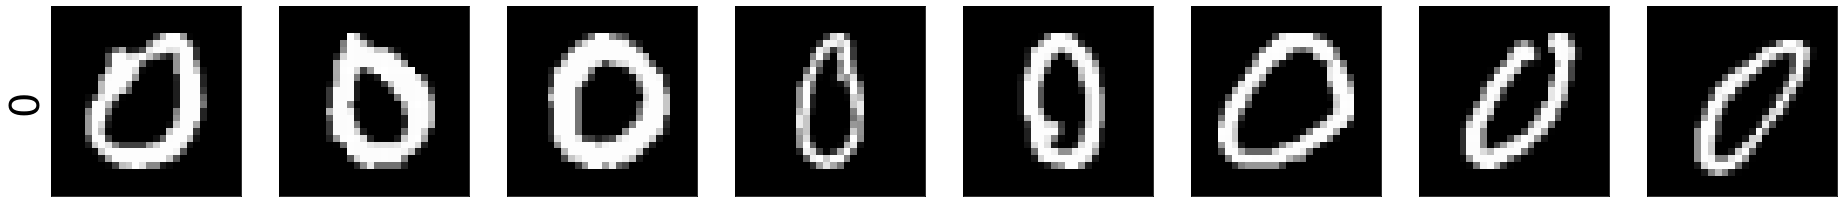

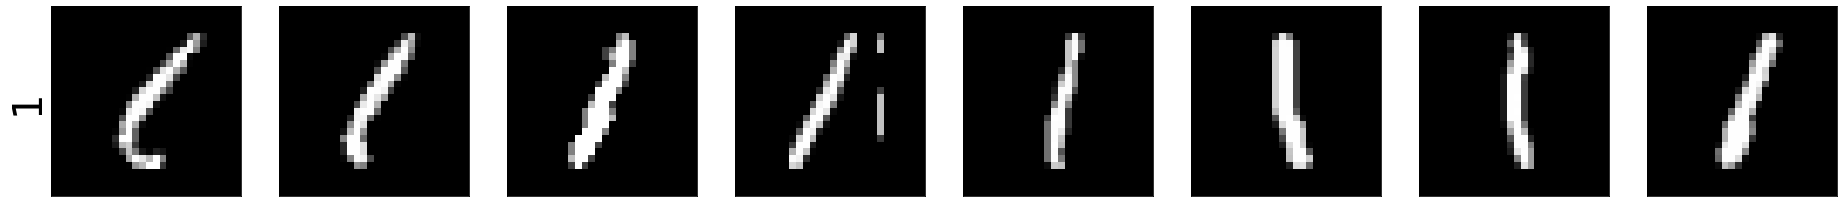

In [5]:
X = torch.load('')
y = torch.load('')
n_samples_list = [len(np.nonzero(y==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
plot_images(1-X[:8, :], ylabel='0')
plot_images(1-X[n_samples:n_samples+8, :], ylabel='1')

In [6]:
cd_dict = dict()

In [7]:
start = time.time()
cd_gb = wrap_transform(GaussianBaryClassifierDestructor())
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_gb.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['GB'] = cd_gb
del(cd_gb)

fitting time: 41.18779516220093 s


In [8]:
start = time.time()
cd_nb = wrap_transform(NaiveBaryClassifierDestructor())
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_nb.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['NB'] = cd_nb
del(cd_nb)

fitting time: 19.347018480300903 s


In [ ]:
start = time.time()

cd_swd_nb = MSWDBaryClassifierDestructor()
n_layers = 250
ndim = 30

# add an inverse normal CDF
Z = cd_swd_nb.initialize(X,y)

# add mSWD-bayes layers
for i in range(n_layers):
    cd_swd_nb, Z = add_one_layer(cd_swd_nb, Z, y, 'nb', ndim=ndim )

# add a normal CDF
Z = cd_swd_nb.end(Z, y)
del(Z)
print(f'fitting time: {time.time()-start} s')
cd_dict['mSWD-NB'] = cd_swd_nb
del(cd_swd_nb)    

In [10]:
start = time.time()
cd_dd = create_deep_density_cd(n_canonical_destructors=10)
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore boundary warnings
    cd_dd.fit_transform(X, y)
print(f'fitting time: {time.time()-start} s')
cd_dict['DD'] = cd_dd
del(cd_dd)    

fitting time: 307.3020923137665 s


## Evaluation

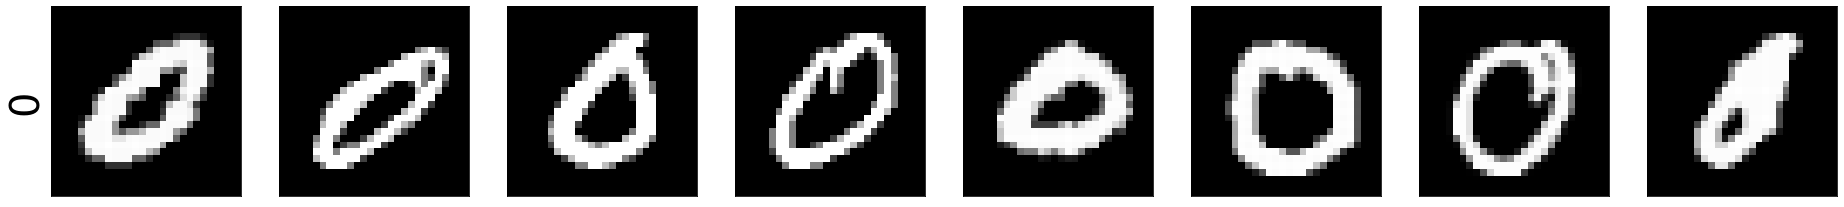

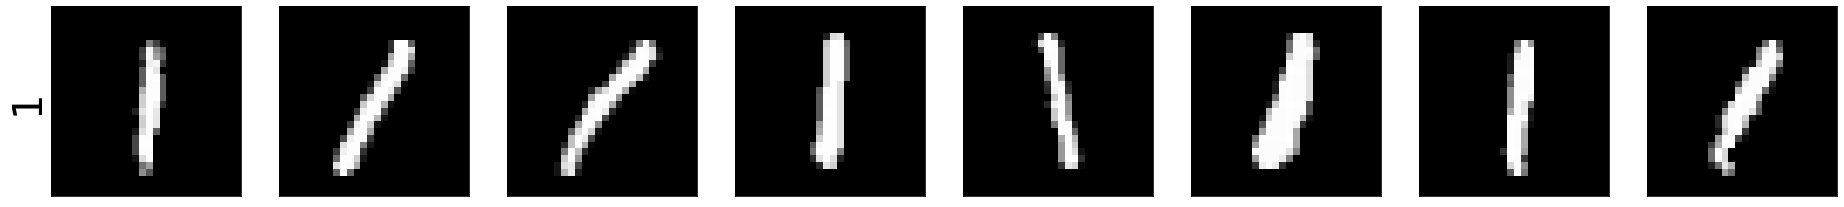

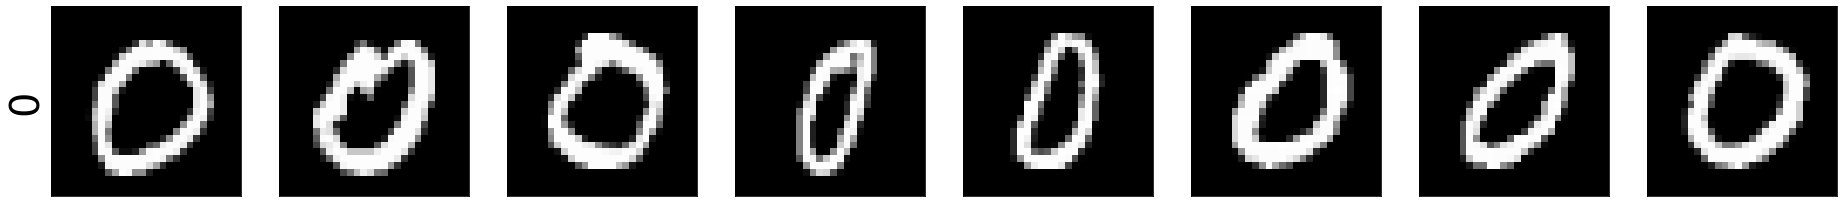

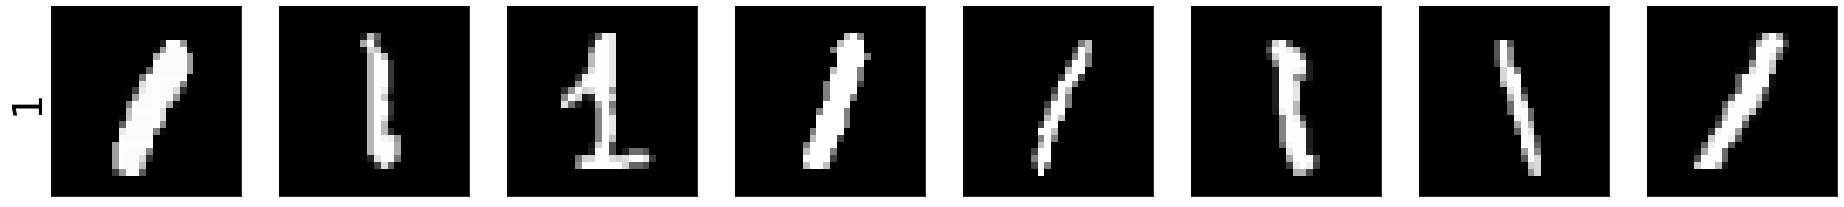

In [11]:
X_cnn = torch.load('')
y_cnn = torch.load('')
X_eval = torch.load('')
y_eval = torch.load('')

X = np.concatenate((X_cnn, X_eval))
y = np.concatenate((y_cnn, y_eval))

n_samples_list = [len(np.nonzero(y==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
n_split = 1500

plot_images(1-X_cnn[:8, :], ylabel='0')
plot_images(1-X_cnn[n_split:n_split+8, :], ylabel='1')
plot_images(1-X_eval[:8, :], ylabel='0')
plot_images(1-X_eval[n_samples-n_split:n_samples-n_split+8, :], ylabel='1')



In [26]:
def plot_images_more(X_list, input_size=(1, 28, 28), fig_height=4, title=None, ylabel=None, vmin=-1, vmax=0):
    n_images = X_list[0].shape[0]
    fig, axes = plt.subplots(3, n_images, figsize=(fig_height * n_images, 3*fig_height))
    for i,X in enumerate(X_list):

        if n_images == 1:
            axes = np.array([axes]) # Add dimension
        for x, ax in zip(X, axes[i]):
            ax.imshow(-x.reshape(*input_size[1:]), cmap='gray', vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])
        if title is not None:
            fig.suptitle(title, fontsize=40)
        if ylabel is not None:
            axes[i,0].set_ylabel(ylabel[i], fontsize=40)    

def gen_plot(cd_dict, key, X, y, path, shift = 0,show=False):
    cd = cd_dict[key]
    idx=[0+shift,1+shift,2+shift,n_split+shift,n_split+1+shift,n_split+2+shift]
    X = X[idx]
    y = y[idx]
    y_flip = np.concatenate((y[3:], y[: 3]))
    if key in ['GB', 'NB', 'GBNB','DD']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, y_flip)
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, y_flip) 
    print(key) 
    plot_images_more([1-X,1-Z_temp,1-Xflip_temp])   
    plt.savefig(''+ path, bbox_inches='tight')
    plt.show()

NB


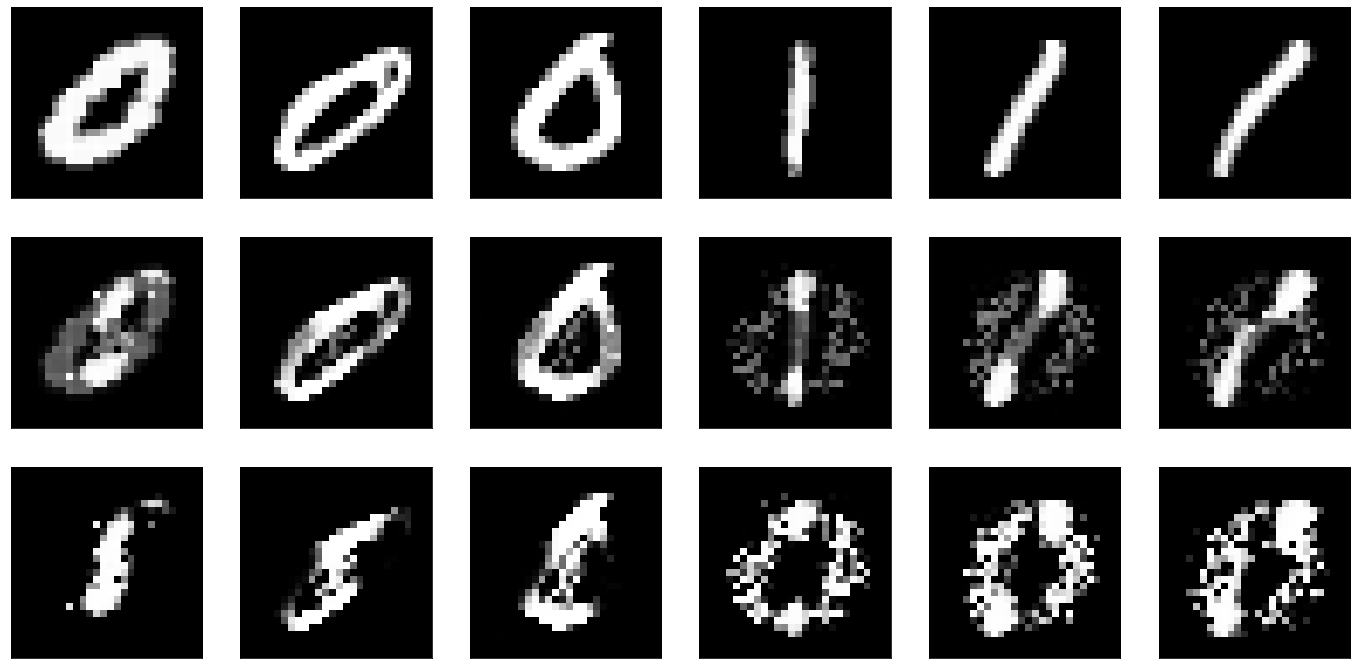

In [27]:
gen_plot(cd_dict,'NB',X,y,'/nb0.png')

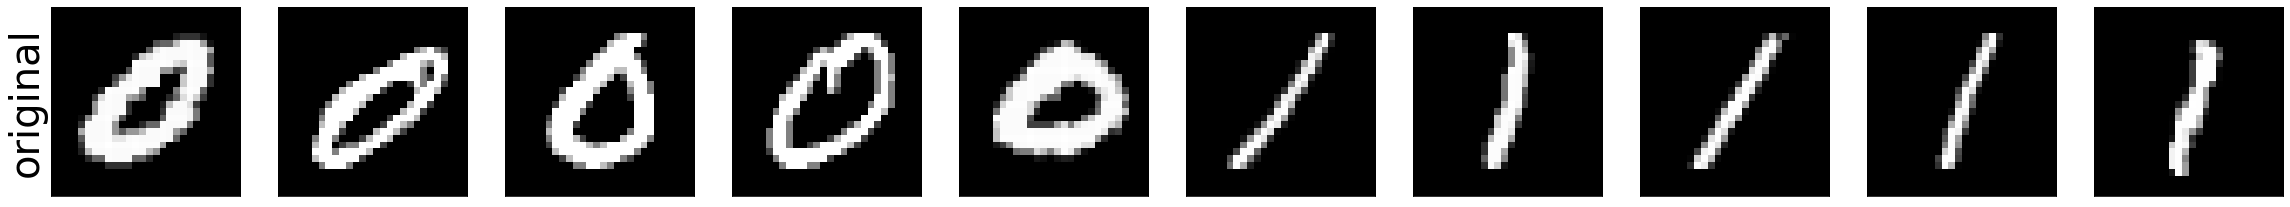

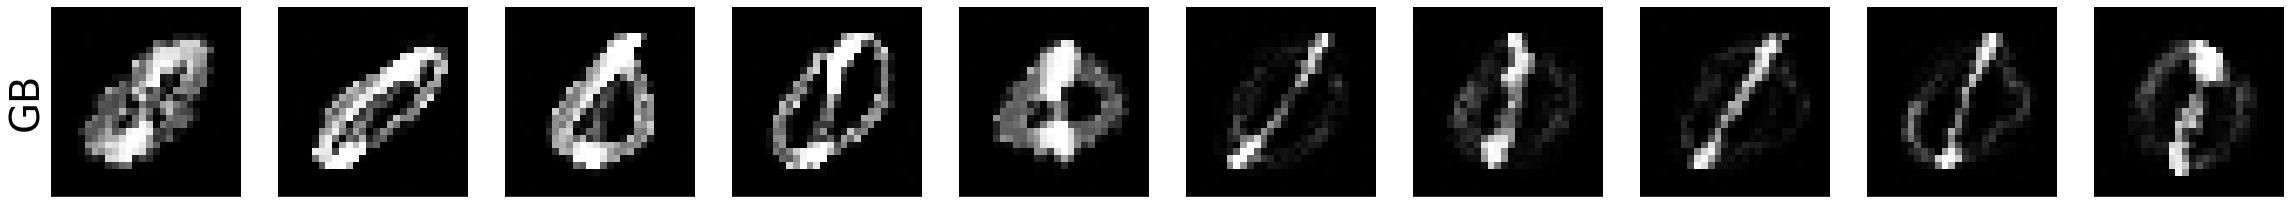

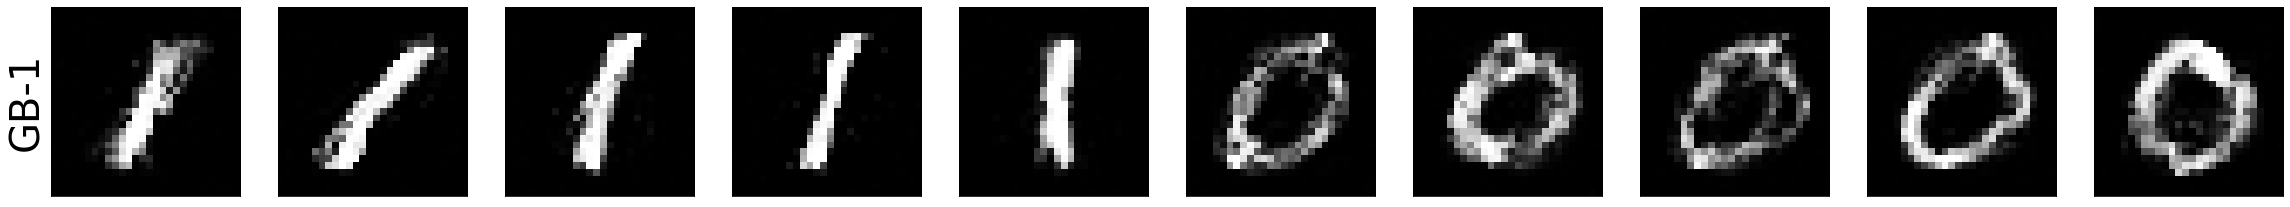

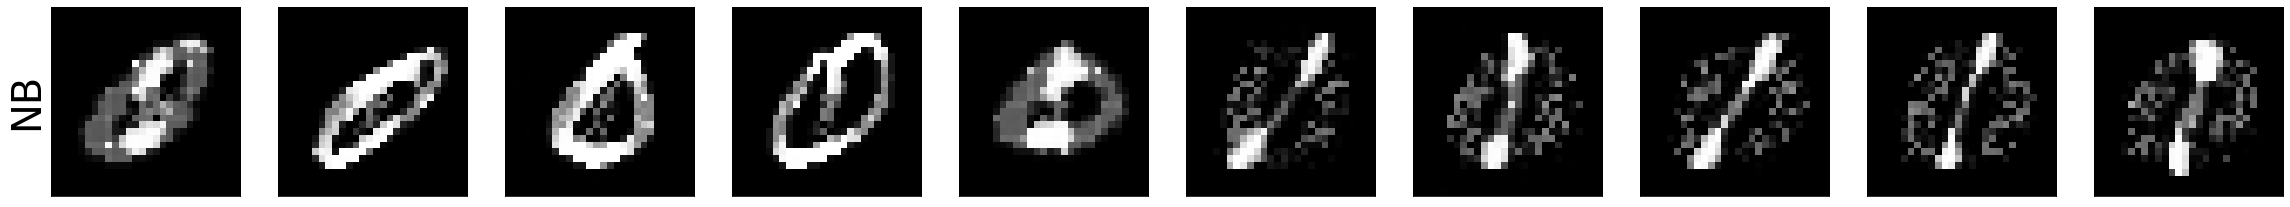

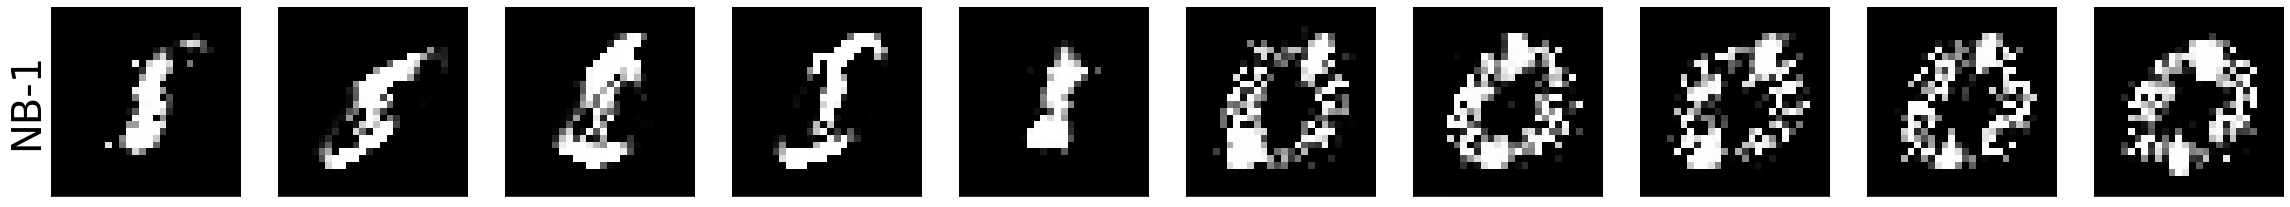

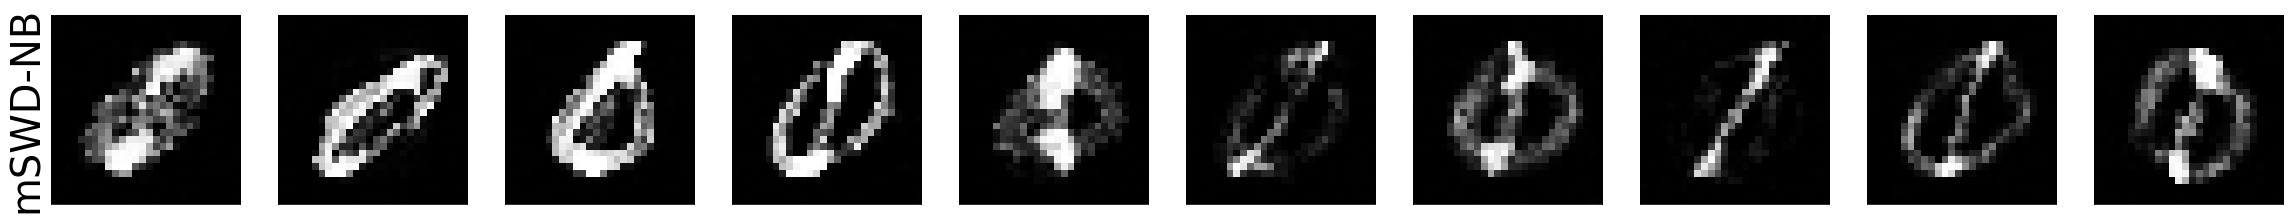

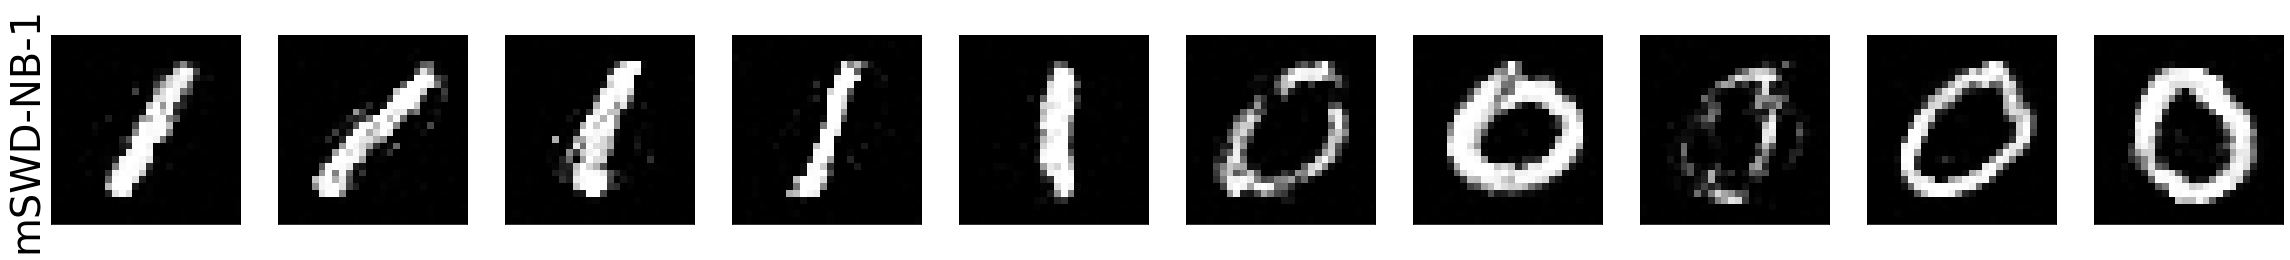

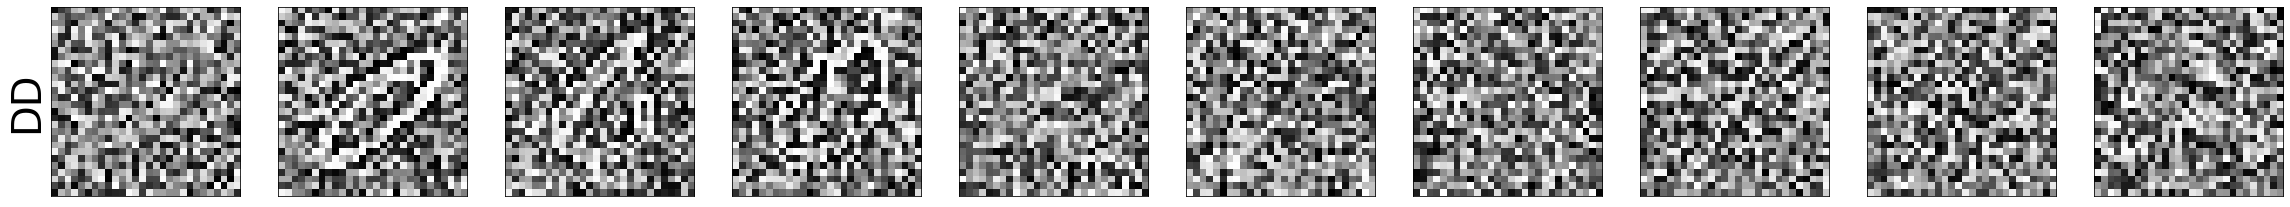

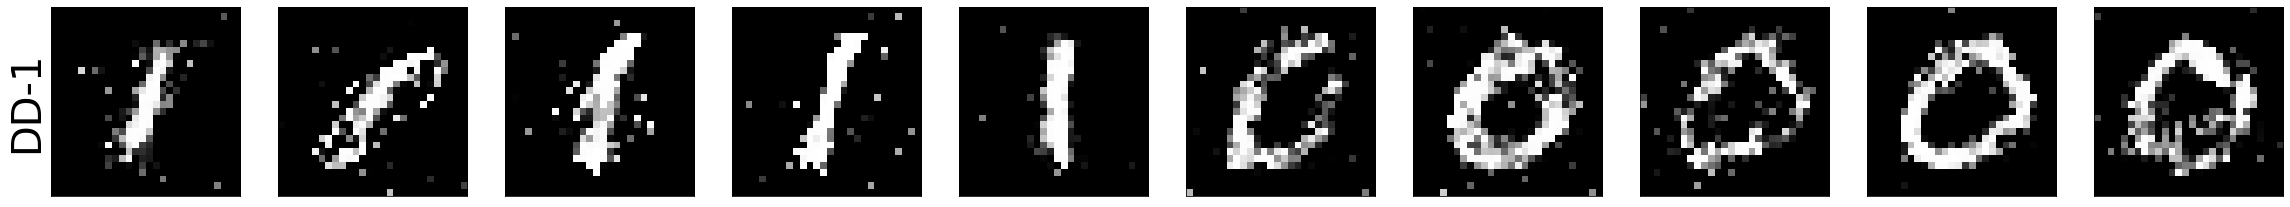

In [13]:
Z_dict = dict()
Xflip_dict = dict()

idx = [0,1,2,3,4,n_samples,n_samples+1,n_samples+2,n_samples+3,n_samples+4]
y_flip = 1-y
plot_images(1-X[idx, :], ylabel='original')
plt.show()

for key, cd in cd_dict.items():
    if key in ['GB', 'NB', 'GBNB','DD']:
        Z_temp = cd.transform(X, y)
        Xflip_temp = cd.inverse_transform(Z_temp, y_flip)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp
    else:
        Z_temp = cd(X, y)
        Xflip_temp = cd.inverse(Z_temp, y_flip)
        Z_dict[key] = Z_temp
        Xflip_dict[key] = Xflip_temp        
    plot_images(1-Z_temp[idx, :], ylabel=key)
    plot_images(1-Xflip_temp[idx, :], ylabel=key+'-1')
    plt.show()

transportation cost of GB is 24.975406646728516
transportation cost of NB is 28.115406036376953
transportation cost of mSWD-NB is 32.88032150268555
transportation cost of DD is 235.16412353515625


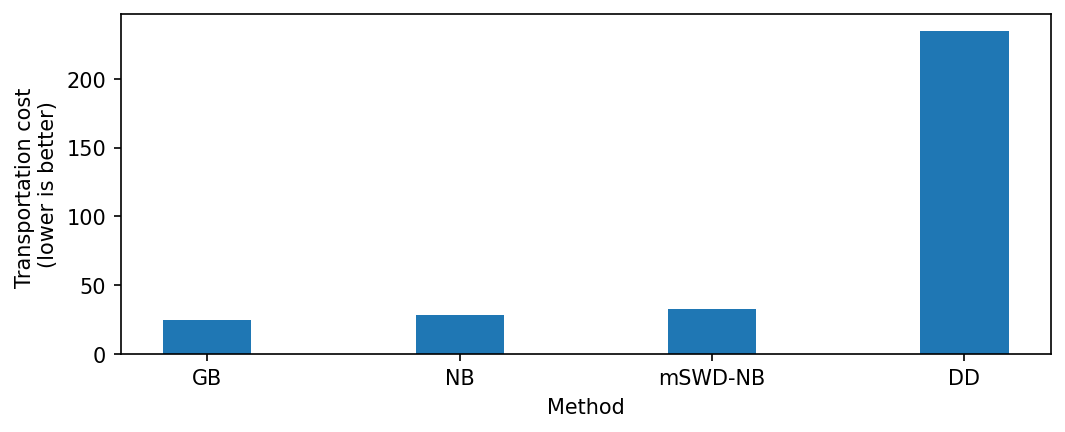

In [14]:
cost_dict = dict()
for key,Z in Z_dict.items():
    cost_temp = transport_cost(X, Z, y)
    cost_dict[key] = cost_temp
    print('transportation cost of '+key+f' is {cost_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = list(cd_dict.keys())
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(cost_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Transportation cost \n(lower is better)')
plt.show()

In [15]:
def part_wd(X,Xp,partition = 500,norm_var=False,eps=1e-4,max_iter=100):
    sinkhorn = SinkhornDistance(eps=eps, max_iter=max_iter)
    n_samples = X.shape[0]
    idx = 0
    avg_wd = 0
    while idx < n_samples-partition:
        
        avg_wd += partition * sinkhorn(X[idx:idx+partition],Xp[idx:idx+partition])
        idx += partition
    
    partition = n_samples - idx
    avg_wd += partition * sinkhorn(X[idx:idx+partition],Xp[idx:idx+partition])

    if norm_var:
        avg_wd = avg_wd/torch.var(X) 
    
    return avg_wd/n_samples


In [16]:
def empirical_wd(X, Z, y, n_samples, weight = None, norm_var=False, eps=1e-4, max_iter=100): 
    # X - original X
    # Z - flipped X

    X = torch.Tensor(X)
    Z = torch.Tensor(Z)
    classes = unique_labels(y)
    n_classes = len(classes)
    # prepare flipped label
    y_flip = 1-y

    if weight is None:
        weight = np.ones(n_classes) / n_classes 

    wd = 0
    # empirical expectation
    for n,l in enumerate(classes):
        sel = np.nonzero(y==l)[0]
        X_temp = X[sel]
        # find Z from another class
        sel = np.nonzero(y_flip==l)[0]
        Z_temp = Z[sel]
        wd += part_wd(X_temp,Z_temp, norm_var = norm_var,eps=eps,max_iter=max_iter) * weight[n]

    return wd

emprical WD of GB is 27.71811866760254
emprical WD of NB is 60.01013946533203
emprical WD of mSWD-NB is 23.02194595336914
emprical WD of DD is 39.0789794921875


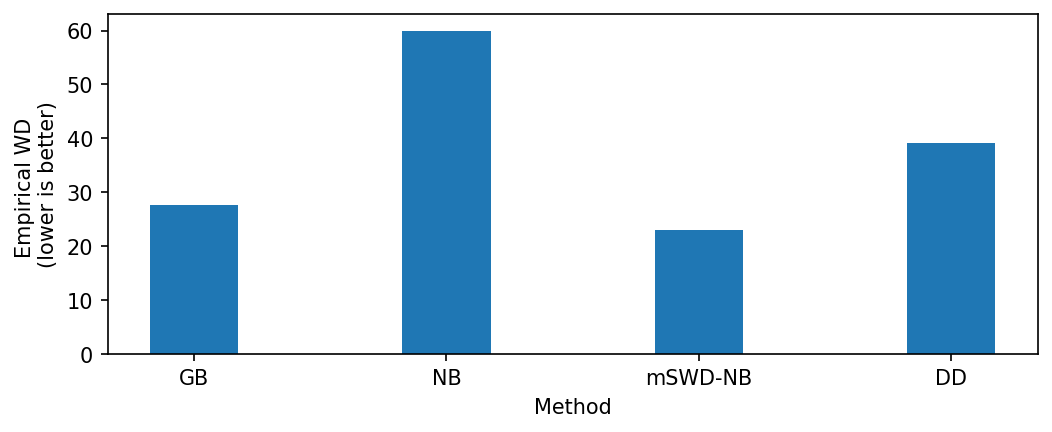

In [17]:
wd_dict = dict()
for key,Xflip in Xflip_dict.items():
    wd_temp = empirical_wd(X, Xflip, y,n_samples,weight=None)
    wd_dict[key] = wd_temp
    print('emprical WD of '+key+f' is {wd_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = list(cd_dict.keys())
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(wd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Empirical WD \n(lower is better)')
plt.show()

emprical WD of GB is 292.6189270019531
emprical WD of NB is 654.9619140625
emprical WD of mSWD-NB is 235.50942993164062
emprical WD of DD is 427.5523376464844


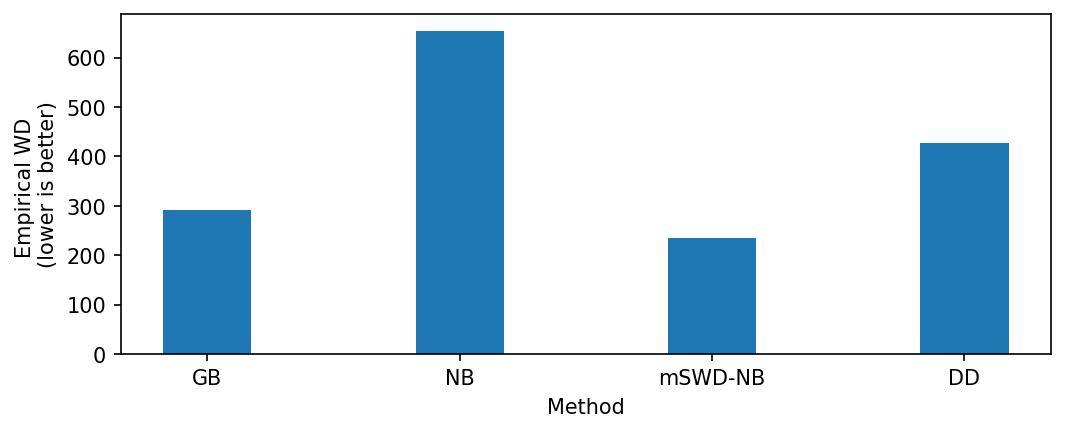

In [18]:
wd_dict = dict()
for key,Xflip in Xflip_dict.items():
    wd_temp = empirical_wd(X, Xflip, y,n_samples,weight=None,norm_var = True)
    wd_dict[key] = wd_temp
    print('emprical WD of '+key+f' is {wd_temp}')
    
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
labels = list(cd_dict.keys())
x_axis = np.arange(len(labels))
ax.bar(x_axis, list(wd_dict.values()), 0.35)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_xlabel('Method')
ax.set_ylabel('Empirical WD \n(lower is better)')
plt.show()

In [19]:
saving_digit = True

In [20]:
root_dir = ''

In [21]:
from torchvision import utils as vutils
 
def save_image_tensor(input_tensor: torch.Tensor, filename):
    """
         Save tensor as picture
         :param input_tensor: tensor to save
         :param filename: saved file name
    """
    assert (len(input_tensor.shape) == 4 and input_tensor.shape[0] == 1)
         # Make a copy
    input_tensor = input_tensor.clone().detach()
         # To cpu
    input_tensor = input_tensor.to(torch.device('cpu'))
         # Denormalization
    # input_tensor = unnormalize(input_tensor)
    vutils.save_image(input_tensor,filename)

In [22]:
# saving real data

if saving_digit:

    real_dir = os.path.join(root_dir, 'real')
    for c in class_list:
        class_dir = os.path.join(real_dir,f'{c}')
        X_c = torch.Tensor(X)[y==c]
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        for i in range(X_c.shape[0]):
            x_temp = X_c[i,:].view(1,1,28,28)
            save_image_tensor(x_temp,os.path.join(class_dir,f'{i}.png'))

    # saving other data

    for key,Xflip in Xflip_dict.items():

        model_dir = os.path.join(root_dir,key)
        for c in class_list:
            class_dir = os.path.join(model_dir,f'{c}')
            X_c = torch.Tensor(Xflip)[np.nonzero(y_flip==c)[0]]
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            for i in range(X_c.shape[0]):
                x_temp = X_c[i,:].view(1,1,28,28)
                save_image_tensor(x_temp,os.path.join(class_dir,f'{i}.png'))
